###### Reduced Events Table

__Description__: Reduced excess rainfall is calculated for each event using a user-specified stormwater removal rate, capacity, and efficiency.

__Input__: A JSON file containing the incremental excess rainfall for a suite of events which may have different durations and boundary condition names, and the stormwater removal rate, capacity, and efficiency.

__Output__: 

- The unreduced incremental excess rainfall for each event as a JSON.

- The incremental reduced excess rainfall and lateral inflow hydrographs for each event as a JSON.

- A metadata file containing the stormwater removal rate, the stormwater capacity, the stormwater efficiency, and the seed of the random number generator.

---

## A. Load Libraries, Parameters, and Data:

### Libraries:

In [1]:
import sys
sys.path.append('core')
import hydromet_reduced
from hydromet import*

### Parameters: 

#### Papermill (site specific):

##### Convert all paths to objects:

In [3]:
outputs_dir = pl.Path(outputs_dir)
pluvial_params_dir = pl.Path(pluvial_params_dir)

##### Set the base filestem for reading/writing files:

In [4]:
filestem = '{0}_{1}_{2}'.format(Project_Area, Pluvial_Model, BCN)

### Data:
#### Stormwater removal rate, capacity, and efficiency:

In [5]:
rate, maxcap, efficiency = get_stormwater_rate_cap(pluvial_params_dir, BCN, rate_column, capacity_column, efficiency_column, display_print)

,Pluvial Domain,Shapefile,Curve Number,SW Infrastructure (YES or NO),SW Rate (in/30min),SW Capacity (in),SW Efficiency,Comments
7,D30,PluvialDomain_V5.shp,82.591687,YES,0.57,4.25,0.75,Main domain


None
SW Rate: 0.57 in/30min
SW Capacity: 4.25 in/unit area
SW Efficiency: 75.0 percent


##### Adjust stormwater rate and capacity by stormwater efficiency:

In [6]:
adj_rate, adj_maxcap = adj_stormwater_rate_cap(rate, maxcap, efficiency, display_print)

Adjusted SW Rate: 0.4275 in/30min
Adjusted SW Capacity: 3.1875 in/unit area


#### Lateral inflow domains:

In [7]:
lid = get_lateral_inflow_domains(pluvial_params_dir, BCN, display_print)

,Pluvial Domain,Lateral Inflow Domain,Lateral Inflow Area (miles^2)
37,D30,L51,2.11
38,D30,L52,2.50


None


#### Excess rainfall data:

In [8]:
with open(outputs_dir/'{}.json'.format(filestem)) as f:
    EventsTable = json.load(f)

##### Extract the durations:

In [9]:
durations = list(EventsTable.keys())
print('Durations:', durations)

Durations: ['H06', 'H12', 'H24', 'H96']


---

## B. Calculate Reduced Excess Rainfall:

Duration: H06
Time Step: 0.5 Hours
Adjusted rate: 0.4275 Adjusted maximum capacity: 3.1875
Duration: H12
Time Step: 0.5 Hours
Adjusted rate: 0.4275 Adjusted maximum capacity: 3.1875
Duration: H24
Time Step: 0.5 Hours
Adjusted rate: 0.4275 Adjusted maximum capacity: 3.1875
Duration: H96
Time Step: 1.0 Hours
Adjusted rate: 0.855 Adjusted maximum capacity: 3.1875


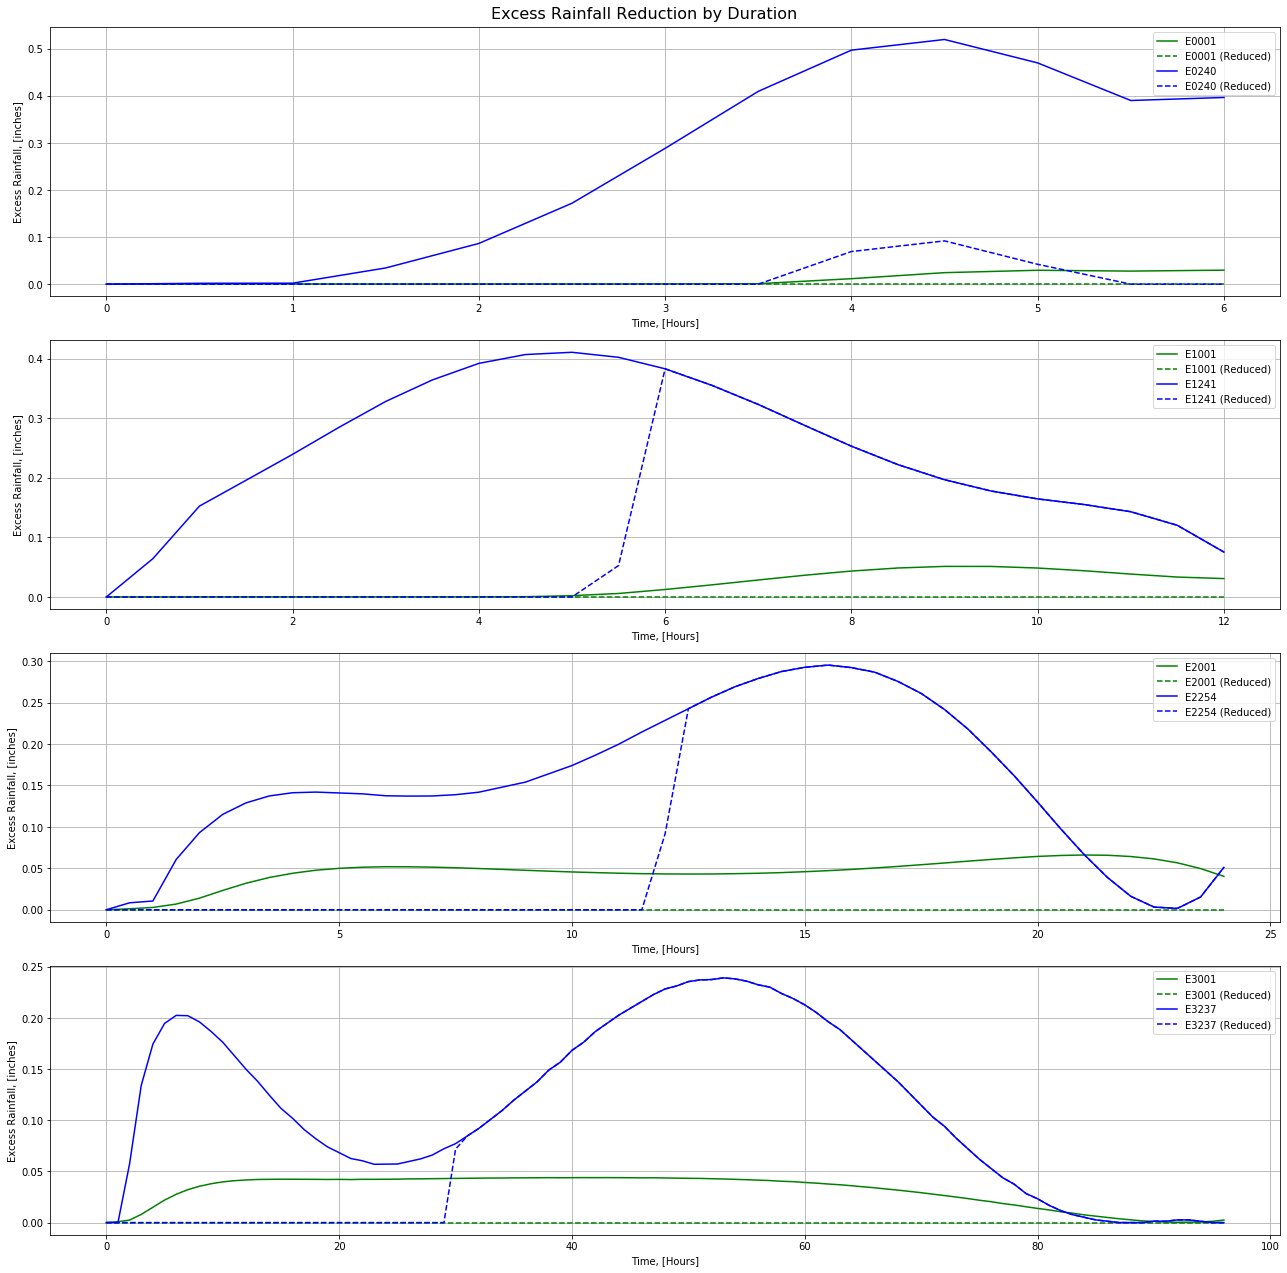

In [10]:
ReducedTable, StormwaterTable, SW_variables = hydromet_reduced.main(EventsTable, durations, BCN, rate = adj_rate, maxcap = adj_maxcap, 
                                                                            display_print = display_print, display_plots = display_plots)

---

## C. Calculate the Lateral Inflow Hydrographs:

Lateral Inflow Domains: ['L51', 'L52', 'L53', 'L57', 'L58', 'L69', 'L70', 'L71']


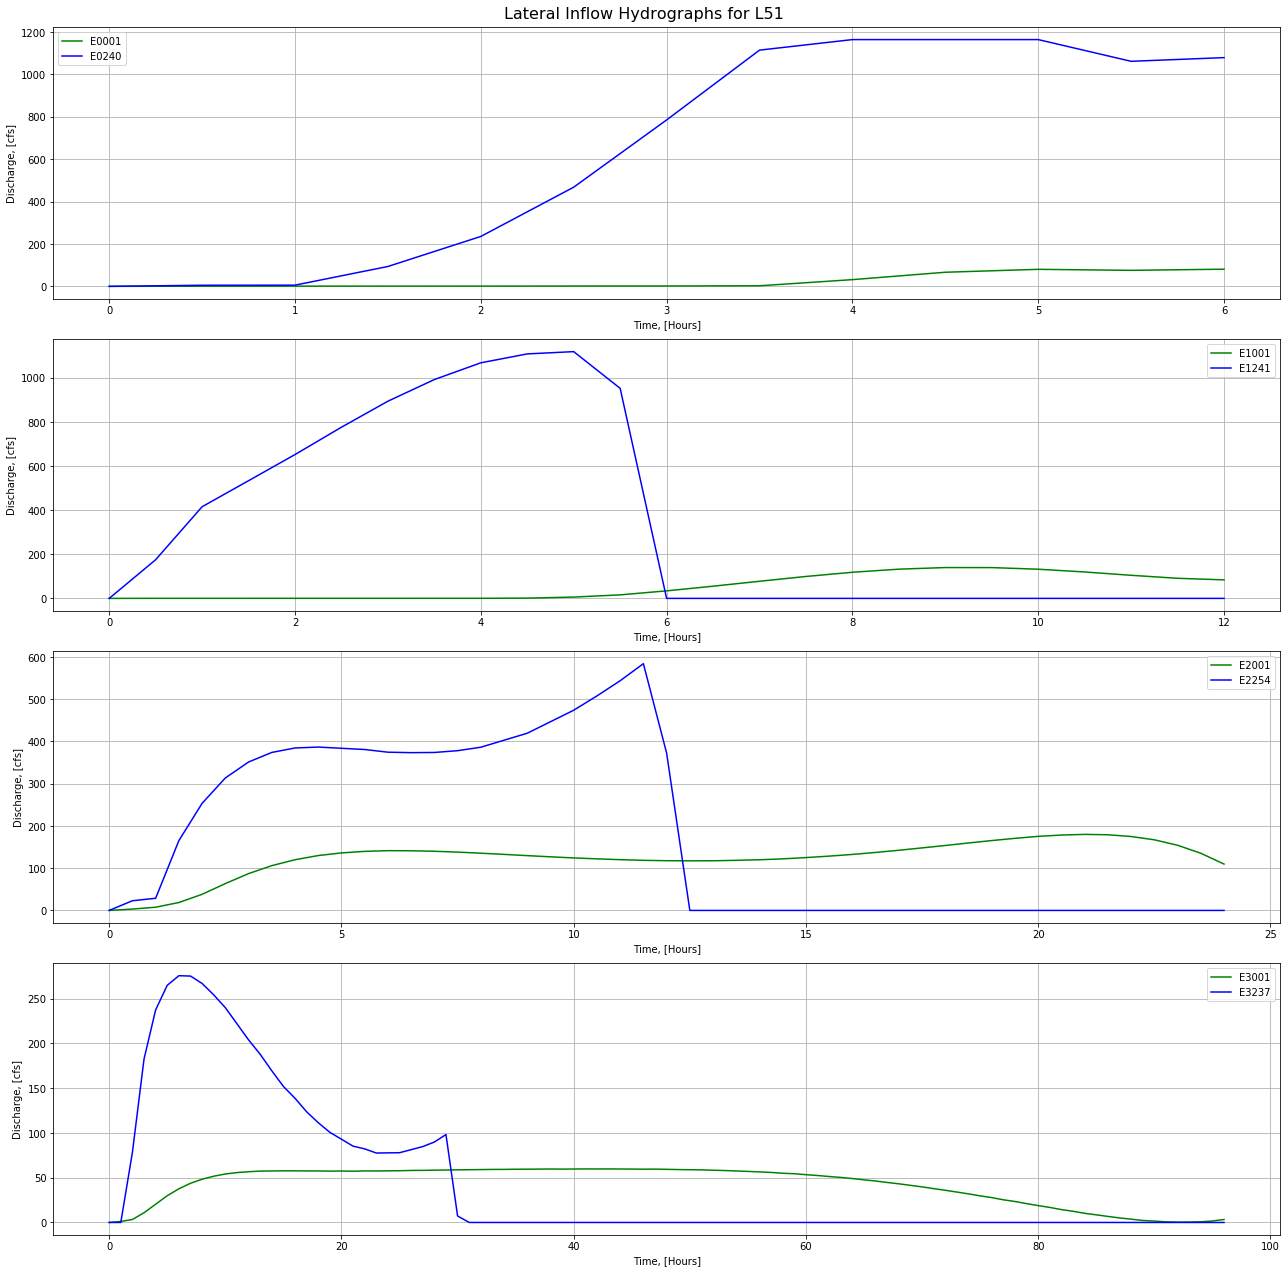

In [11]:
if lid.shape[0]>0:
    ReducedTable = calc_lateral_inflow_hydro(lid, ReducedTable, StormwaterTable, durations, BCN, display_print, display_plots, plot_lid_num = 0)

---

## D. Save the Results:

### Unreduced excess rainfall:

In [12]:
with open(outputs_dir/'{0}_Unreduced.json'.format(filestem), 'w') as f:
    json.dump(EventsTable, f)

### Reduced excess rainfall:

In [13]:
with open(outputs_dir/'{}.json'.format(filestem), 'w') as f:
    json.dump(ReducedTable, f)

### Metadata:

In [14]:
with open(outputs_dir/'{0}_SWMetadata.json'.format(filestem), 'w') as f:
    json.dump(SW_variables, f)

---

## END